In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap
import seaborn as sns
from datetime import datetime
from typing import List, Tuple, Dict
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import stats


from validate_dowscaled_et import prepare_data_for_plotting
from utils.plot_config import set_plot_style
from time_series_metrics import calculate_metrics

from utils import date_utils, ee_utils, data_utils
from utils.ee_utils import back_to_float, back_to_int

import re

import warnings

warnings.filterwarnings("ignore")

In [3]:
ee.Initialize(project="thurgau-irrigation")

### Import validation data and WaPOR ET data

In [4]:
years_to_process = range(2018, 2022)

asset_name = "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_test_refactor"
et_collection_downscaled = ee_utils.merge_collections(years_to_process, asset_name)

et_collection = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_300m_TG_2018-2022"
).filterDate("2018-01-01", "2022-01-01")

dates_for_validation = date_utils.store_collection_dates(et_collection)

In [5]:
dates_for_validation

,date
0,2018-10-01
1,2018-10-11
2,2018-10-21
3,2018-11-01
4,2018-11-11
...,...
139,2021-08-11
140,2021-08-21
141,2021-09-01
142,2021-09-11


In [6]:
# image_id = "2_WaPOR_ET_downscaled_2021-02_D2"
# date_str = "2021-02-11"

# updated_et_collection = date_utils.update_image_timestamp(et_collection, image_id, date_str)
# et_collection = updated_et_collection

In [7]:
et_collection.first().propertyNames().getInfo()

['system:time_start',
 'Month',
 'Year',
 'system:footprint',
 'system:version',
 'system:id',
 'system:asset_size',
 'system:index',
 'system:bands',
 'system:band_names']

In [8]:
# # Fix image with missing date
# image_id = "2_WaPOR_ET_downscaled_2021-02_D2"
# image = et_collection.filter(ee.Filter.eq('system:index', image_id)).first()

# date_str = "2021-02-11"
# date = datetime.strptime(date_str, "%Y-%m-%d")

# image_with_date = image.set("system:time_start", date.timestamp() * 1000)
# image_with_date.date().getInfo()

## Rietholzbach

In [9]:
rietholzbach_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021").sort("system:time_start")

In [10]:
rietholzbach_validation_df = geemap.ee_to_df(rietholzbach_validation_et_collection)

In [11]:
def resample_and_interpolate_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample a DataFrame with a date column, setting daily frequency and interpolating missing values.

    Args:
        df (DataFrame): The input DataFrame containing a date column named 'date_[YYYYmmdd]'.

    Returns:
        DataFrame: A DataFrame resampled to daily frequency with interpolated values.
    """
    df["date"] = pd.to_datetime(df["date_[YYYYmmdd]"])
    df = df.drop(columns=["date_[YYYYmmdd]"])
    df = df.set_index("date")
    df = df.resample("D").asfreq()
    df = df.interpolate(method="time")
    return df

In [12]:
rietholzbach_validation_df = resample_and_interpolate_df(rietholzbach_validation_df)

In [13]:
rietholzbach_validation_ET = data_utils.aggregate_time_series(rietholzbach_validation_df, dates_for_validation)
rietholzbach_validation_ET['date'] = pd.to_datetime(rietholzbach_validation_ET['date'])
rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"] = rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"].round(0)

In [14]:
point = rietholzbach_validation_et_collection.first().geometry()
raster_collection = ee_utils.extract_pixel_values(et_collection, point, band="ET")
raster_collection_downscaled = ee_utils.extract_pixel_values(et_collection_downscaled, point, band="downscaled")

In [15]:
Map = geemap.Map()

vis_params = {
    "bands": ["ET"],
    "min": 0,
    "max": 5,
    "palette": ["white", "blue", "green", "yellow", "red"],
}

image = ee.Image(et_collection.toList(et_collection.size()).get(20))

Map.addLayer(image, vis_params, "ET")
Map.addLayer(point, {"color": "red"}, "Point")
Map.setCenter(8.2275, 47.6966, 8)
Map

Map(center=[47.6966, 8.2275], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [16]:
waport_df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
waport_df["evapotranspiration[mm/d]"] = (waport_df["pixel_value"])
waport_df["date"] = pd.to_datetime(waport_df["date"])

waport_df_downscaled = geemap.ee_to_df(ee.FeatureCollection(raster_collection_downscaled))
waport_df_downscaled["evapotranspiration[mm/d]"] = (waport_df_downscaled["pixel_value"]/100).round(0)
waport_df_downscaled["date"] = pd.to_datetime(waport_df_downscaled["date"])

In [17]:
waport_df

,date,pixel_value,evapotranspiration[mm/d]
0,2018-10-01,1,1
1,2018-10-11,1,1
2,2018-10-21,0,0
3,2018-11-01,0,0
4,2018-11-11,0,0
...,...,...,...
139,2021-08-11,3,3
140,2021-08-21,1,1
141,2021-09-01,2,2
142,2021-09-11,1,1


### Visually validate the WAPOR ET data

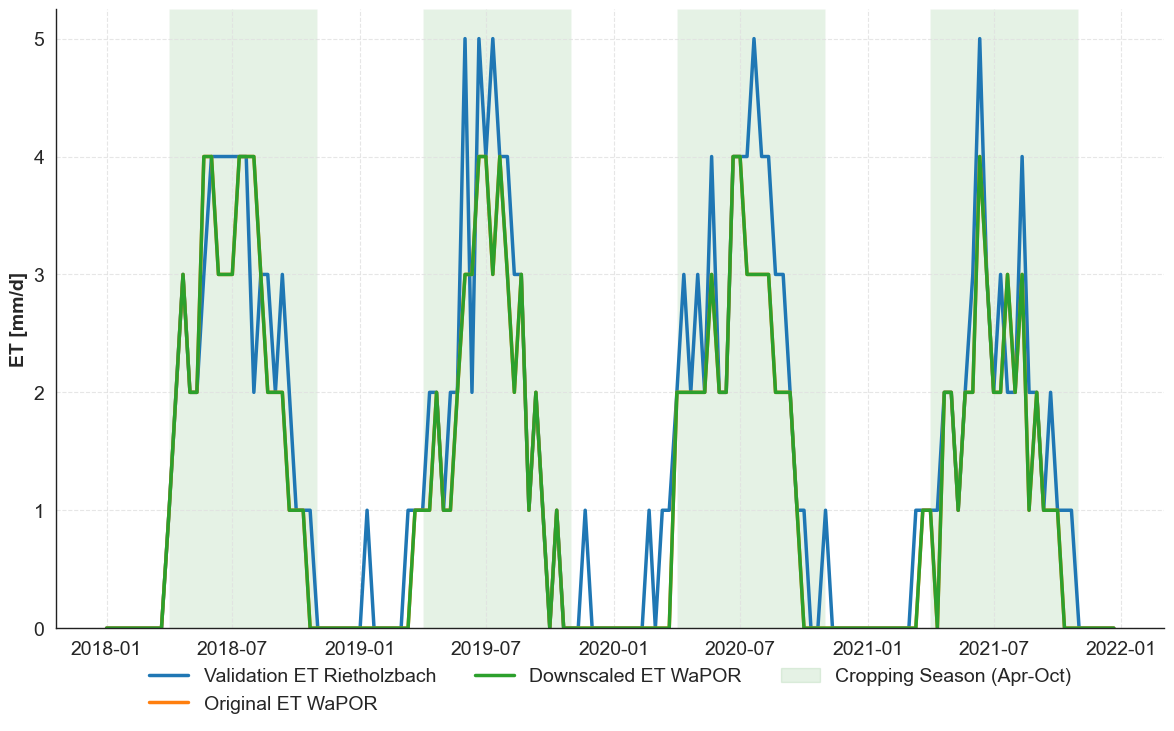

In [18]:
set_plot_style()  # Assuming this function is defined elsewhere

plt.figure(figsize=(12, 8))  # Increased height to accommodate bottom legend

# Plot the data
sns.lineplot(
    data=rietholzbach_validation_ET,
    x="date",
    y="average_evapotranspiration_[mm/d]",
    label="Validation ET Rietholzbach",
    color="#1f77b4",
)
sns.lineplot(
    data=waport_df,
    x="date",
    y="evapotranspiration[mm/d]",
    label="Original ET WaPOR",
    color="#ff7f0e",
)
sns.lineplot(
    data=waport_df_downscaled,
    x="date",
    y="evapotranspiration[mm/d]",
    label="Downscaled ET WaPOR",
    color="#2ca02c",
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/d]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_validation_ET["date"].dt.year.min(),
    rietholzbach_validation_ET["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig(
    "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_validation_Rietholzbach_10d_aggregate_from_coarse.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Quantitative validation

In [19]:
metrics = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df['evapotranspiration[mm/d]'])
metrics_downscaled = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df_downscaled['evapotranspiration[mm/d]'])

metrics, metrics_downscaled

({'R-squared': np.float64(-1.4),
  'Correlation Coefficient': np.float64(-0.0),
  'Dynamic Time Warping Distance': 6.0,
  'Mean Absolute Error': np.float64(1.6),
  'Root Mean Square Error': np.float64(2.1),
  'Normalized Root Mean Square Error': np.float64(0.5)},
 {'R-squared': np.float64(0.8),
  'Correlation Coefficient': np.float64(0.9),
  'Dynamic Time Warping Distance': 5.3,
  'Mean Absolute Error': np.float64(0.3),
  'Root Mean Square Error': np.float64(0.6),
  'Normalized Root Mean Square Error': np.float64(0.2)})

In [20]:
metrics

{'R-squared': np.float64(-1.4),
 'Correlation Coefficient': np.float64(-0.0),
 'Dynamic Time Warping Distance': 6.0,
 'Mean Absolute Error': np.float64(1.6),
 'Root Mean Square Error': np.float64(2.1),
 'Normalized Root Mean Square Error': np.float64(0.5)}

## Comparing WaPOR ET with Rietholzbach ET and Landsat ET

### Getting the landsat image and preparing it for plotting

In [21]:
def extract_landsat_evapotranspiration_data(
    point: ee.Geometry, time_period: Tuple[str, str]
) -> pd.DataFrame:
    """
    Extracts evapotranspiration data from the Landsat monthly collection for a given point and time period.

    Args:
        point (ee.Geometry): The geographic point for which to extract data.
        time_period (Tuple[str, str]): A tuple containing the start and end date (YYYY-MM-DD) for filtering the data.

    Returns:
        pd.DataFrame: A DataFrame containing the evapotranspiration data for the specified point and time period.
    """
    # Load the evapotranspiration image collection
    ET_landsat_cantons = ee.ImageCollection(
        "projects/thurgau-irrigation/assets/Thurgau/Landsat_ET_gap_filled_2018-2022"
    ).map(lambda img: back_to_float(img, 100))

    # Extract pixel values for the given point
    landsat_ET_fc = ee_utils.extract_pixel_values(
        ET_landsat_cantons, point, band="fitted_ET"
    )
    landsat_ET_df = geemap.ee_to_df(landsat_ET_fc)

    # Convert date column to datetime
    landsat_ET_df["date"] = pd.to_datetime(landsat_ET_df["date"])

    # Set all dates to the first day of their respective months
    landsat_ET_df["date"] = landsat_ET_df["date"].dt.to_period("M").dt.to_timestamp()

    # Rename pixel value column to evapotranspiration
    landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df["pixel_value"].apply(
        lambda x: 0 if x < 0 else x
    )

    # Filter DataFrame for the specified time period
    start_date, end_date = time_period
    landsat_ET_df = landsat_ET_df[
        (landsat_ET_df["date"] >= start_date) & (landsat_ET_df["date"] <= end_date)
    ]

    # Set NaN values to 0
    landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df[
        "evapotranspiration[mm/month]"
    ].fillna(0)

    return landsat_ET_df

In [22]:
landsat_ET_df = extract_landsat_evapotranspiration_data(point, ("2018-01-01", "2021-12-31"))

In [23]:
landsat_ET_df

,date,pixel_value,evapotranspiration[mm/month]
0,2018-01-01,-5.89,0.00
1,2018-02-01,4.36,4.36
2,2018-03-01,26.00,26.00
3,2018-04-01,53.23,53.23
4,2018-05-01,79.71,79.71
5,2018-06-01,96.87,96.87
6,2018-07-01,101.04,101.04
7,2018-08-01,90.32,90.32
8,2018-09-01,68.53,68.53
9,2018-10-01,NaN,0.00


### Resampling dekadal WaPOR data to monthly data. The resampling is done by multiplying the dekadal data by the number of days in each dekad and then summing the values for each month.

In [ ]:
# wapor_monthly_et = ee_utils.aggregate_to_monthly(et_collection)
# wapor_monthly_et_fc = ee_utils.extract_pixel_values(wapor_monthly_et, point)
# waport_monthly_df = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc))
# waport_monthly_df["evapotranspiration[mm/month]"] = waport_monthly_df["pixel_value"] / 100
# waport_monthly_df["date"] = pd.to_datetime(waport_monthly_df["date"])

Exception: Image.select: Band pattern 'downscaled' did not match any bands. Available bands: [ET]

In [ ]:
dates_for_validation = date_utils.store_collection_dates(wapor_monthly_et)

### Resample Rietholzbach validation data to monthly

In [ ]:
rietholzbach_monthly_ET_df = data_utils.aggregate_time_series(rietholzbach_validation_df, dates_for_validation, aggregation_type="sum")
rietholzbach_monthly_ET_df.rename(columns={"sum_evapotranspiration_[mm/d]": "sum_evapotranspiration_[mm/month]"}, inplace=True)

### Plotting the validation

In [ ]:
plt.figure(figsize=(12, 8))  

# Plot the data
sns.lineplot(
    data=rietholzbach_monthly_ET_df,
    x="date",
    y="sum_evapotranspiration_[mm/month]",
    label="Validation ET Rietholzbach",
    color="#1f77b4",
)
sns.lineplot(
    data=waport_monthly_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Downscaled ET WaPOR",
    color="#ff7f0e",
)
sns.lineplot(
    data=landsat_ET_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Landsat ET",
    color="#9467bd"
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/month]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_monthly_ET_df["date"].dt.year.min(),
    rietholzbach_monthly_ET_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_Landsat_validation_Rietholzbach_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], waport_monthly_df['evapotranspiration[mm/month]'])
print(metrics)
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], landsat_ET_df['evapotranspiration[mm/month]'])
print(metrics)

## Oensingen
### Get validation data

In [25]:
oesnsingen_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020").sort("system:time_start")
oesnsingen_validation_df = geemap.ee_to_df(oesnsingen_validation_et_collection)
oesnsingen_validation_df["date"] = pd.to_datetime(oesnsingen_validation_df["date_[YYYYmmdd]"])
oesnsingen_validation_df = oesnsingen_validation_df.drop(columns=["date_[YYYYmmdd]"])

oesnsingen_validation_df = oesnsingen_validation_df[
    (oesnsingen_validation_df["date"] >= "2018-01-01") & (oesnsingen_validation_df["date"] <= "2020-12-31")
]

oesnsingen_validation_df["evapotranspiration_[mm/month]"] = oesnsingen_validation_df["evapotranspiration_[mm/month]"].round(0).fillna(0)

In [26]:
oensingen_point = oesnsingen_validation_et_collection.first().geometry()

### Get WaPORT ET data for region around Oensingen

In [32]:
years_to_process = [2018, 2019, 2020]

asset_name = "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_oensingen"
et_collection_oensingen = ee_utils.merge_collections(years_to_process, asset_name)


wapor_monthly_et = ee_utils.aggregate_to_monthly(et_collection_oensingen)
wapor_monthly_et_fc = ee_utils.extract_pixel_values(wapor_monthly_et, oensingen_point)
waport_monthly_df = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc))
waport_monthly_df["evapotranspiration[mm/month]"] = waport_monthly_df["pixel_value"] / 100
waport_monthly_df["date"] = pd.to_datetime(waport_monthly_df["date"])


et_collection_original = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/ET_WaPOR_300m_Oensingen_2018-2022"
).filterDate("2018-01-01", "2021-01-01")


wapor_monthly_et_original = ee_utils.aggregate_to_monthly(et_collection_original, bands=["ET"])
wapor_monthly_et_fc_original = ee_utils.extract_pixel_values(wapor_monthly_et_original, oensingen_point, band="ET")
waport_monthly_df_original = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc_original))
waport_monthly_df_original["evapotranspiration[mm/month]"] = waport_monthly_df_original["pixel_value"]
waport_monthly_df_original["date"] = pd.to_datetime(waport_monthly_df_original["date"])

### Get landsat data

In [34]:
# landsat_ET_df_oesnsingen = extract_landsat_evapotranspiration_data(oensingen_point, ("2018-01-01", "2020-12-31")) 

### Plotting

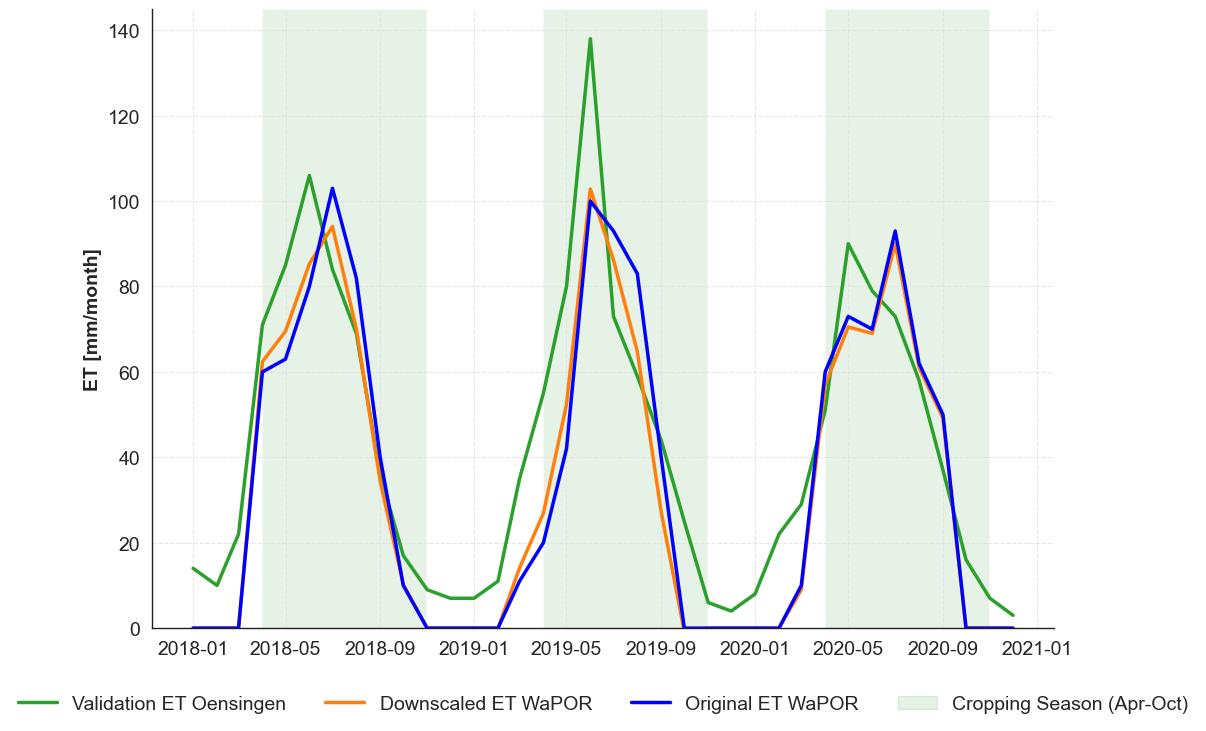

In [35]:
plt.figure(figsize=(12, 8))  

# Plot the data
sns.lineplot(
    data=oesnsingen_validation_df,
    x="date",
    y="evapotranspiration_[mm/month]",
    label="Validation ET Oensingen",
    color="#2ca02c",
)
sns.lineplot(
    data=waport_monthly_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Downscaled ET WaPOR",
    color="#ff7f0e",
)

sns.lineplot(
    data=waport_monthly_df_original,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Original ET WaPOR",
    color="blue",
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/month]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    oesnsingen_validation_df["date"].dt.year.min(),
    oesnsingen_validation_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_Landsat_validation_Oensingen_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
oesnsingen_validation_df = oesnsingen_validation_df.set_index('date')

waport_monthly_df = waport_monthly_df.set_index('date')

landsat_ET_df_oesnsingen = landsat_ET_df_oesnsingen.set_index('date')

# Ensure the index is of datetime type
oesnsingen_validation_df.index = pd.to_datetime(oesnsingen_validation_df.index)
waport_monthly_df.index = pd.to_datetime(waport_monthly_df.index)
landsat_ET_df_oesnsingen.index = pd.to_datetime(landsat_ET_df_oesnsingen.index)

# Now you can calculate the metrics
metrics = calculate_metrics(oesnsingen_validation_df['evapotranspiration_[mm/month]'], 
                            waport_monthly_df['evapotranspiration[mm/month]'])

metrics_landsat = calculate_metrics(oesnsingen_validation_df['evapotranspiration_[mm/month]'],
                                    landsat_ET_df_oesnsingen['evapotranspiration[mm/month]'])

In [ ]:
metrics

In [ ]:
metrics_landsat